In [1]:
import sys
from ase.build import bulk
from ase.visualize.plot import plot_atoms
from ase.build.surfaces_with_termination import surfaces_with_termination
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np
from ase.build import sort
from ase.io.vasp import read_vasp
from ase.build import surface, make_supercell
from ase.build import sort
from ase.geometry import get_layers
import Tools as tl
from ase.visualize import view

## Creo celda ZrO2 2x2 en el plano 1 0 -1 0 y un sitio tipo 'top'

In [2]:
zro2 = read_vasp('Structure/POSCAR')

In [3]:
ZrO2001Oterm = surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=15., termination='O',verbose=True, symmetric=True)

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


## Seleccionar que sitio se quiere hacer en ZrO2

### sitio debe ser igual a 'top','hollow1','hollow2','bridge'

In [4]:
ZrO2001Oterm_2x2_unsorted = [make_supercell(thisurface,[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for thisurface in ZrO2001Oterm]
ZrO2001Oterm_2x2 = sort(ZrO2001Oterm_2x2_unsorted[0])

sitio = 'hollow2'

layer, height = get_layers(ZrO2001Oterm_2x2, (0,0,1), tolerance=0.7)
h_sitio = ZrO2001Oterm_2x2.positions.max(axis=0)[-1]

if sitio == 'top':
    tl.get_adsite(ZrO2001Oterm_2x2, site='top', face='top')
    ontop = tl.make_adstruc(ZrO2001Oterm_2x2, 'RotBotTop', theface='top', thesite='top')

elif sitio == 'hollow1':
    hollow1 = ZrO2001Oterm_2x2.positions[layer == 13].mean(axis=0)[:2]
    hollow1 = np.append(hollow1, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'hollow1': hollow1}}}
    onhollow1 = tl.make_adstruc(ZrO2001Oterm_2x2, 'hollow1', thesite='hollow1', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'hollow1', 'top')

elif sitio == 'hollow2':
    hollow2 = ZrO2001Oterm_2x2.positions[layer == 13][0][:2]
    hollow2 = np.append(hollow2, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'hollow2': hollow2}}}
    onhollow2 = tl.make_adstruc(ZrO2001Oterm_2x2, 'hollow2', thesite='hollow2', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'hollow2', 'top')

elif sitio == 'bridge':
    bridge = ZrO2001Oterm_2x2.positions[layer == 14].mean(axis=0)[:2]
    bridge = np.append(bridge, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'bridge': bridge}}}
    onbridge = tl.make_adstruc(ZrO2001Oterm_2x2, 'bridge', thesite='bridge', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'bridge', 'top')

## Creo celda Zr 1x1, roto, hago simetria, agrego sitio tipo "top"

In [5]:
# co es solo para que tenga otro color, hay qye cambiarlo antes de calcular
zrortho = bulk('Co', crystalstructure='hcp', orthorhombic=True)
Zr10m10 = surfaces_with_termination(zrortho, (0, 1, 0), 5, vacuum=10, termination='Co')[0]
zrsymmetric = tl.make_symmetric(Zr10m10,natoms=3)
Zr10m10_2x2_unsorted = make_supercell(zrsymmetric,[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True)
Zr10m10_2x2 = sort(Zr10m10_2x2_unsorted)

In [6]:
view(Zr10m10_2x2)

<Popen: returncode: None args: ['/data/Anaconda/custom_ase/bin/python', '-m'...>

El loop que había en las ramas anteriores estaba bien, pero había que cambiar el orden de las cosas y aprobecho para ordenar todo un poco

Los angulos a considerar para las rotaciones son:

In [7]:
angs = np.linspace(0,45,4)

In [8]:
notyetrotated = [Zr10m10_2x2.copy() for ang in angs]

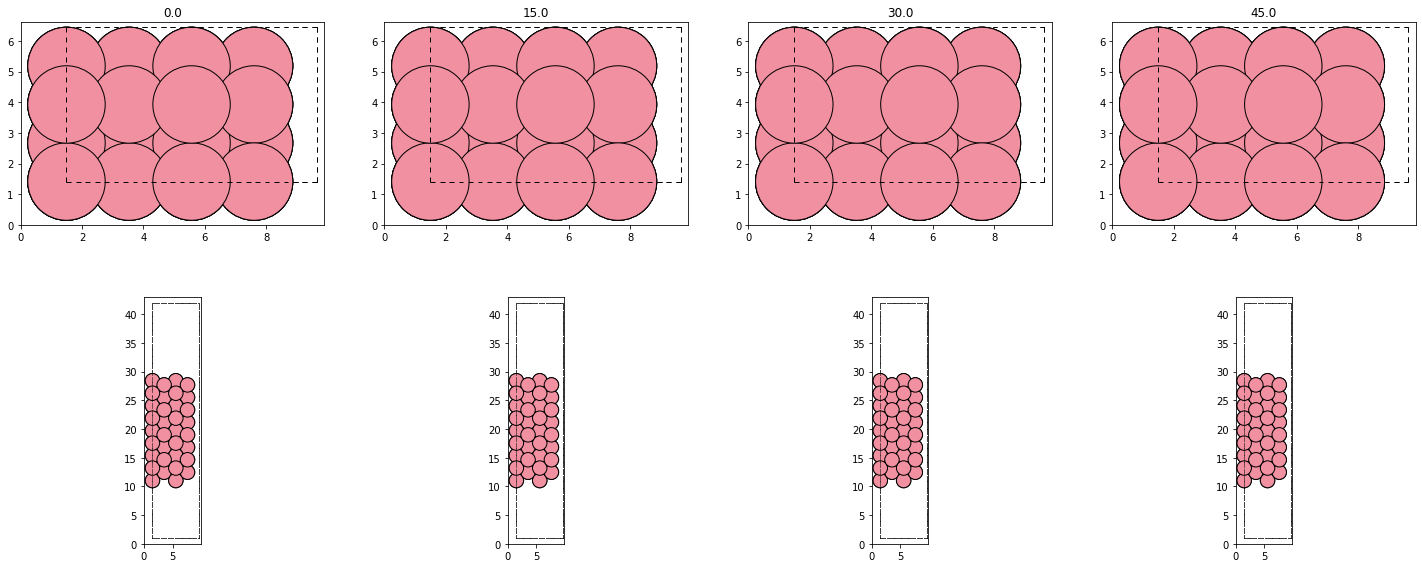

In [9]:
tl.plotcases(notyetrotated, angs)

In [10]:
scaled_rotated = [tl.scalecell(thisatoms, ZrO2001Oterm_2x2.cell.copy()) for thisatoms in notyetrotated]

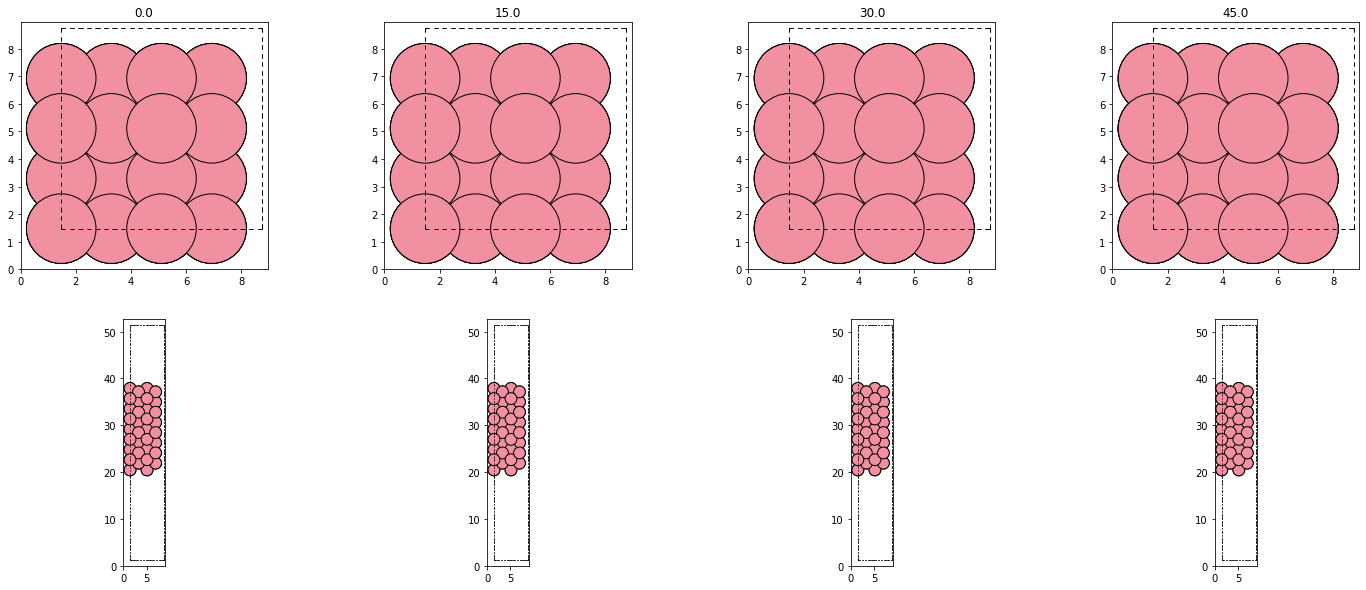

In [11]:
tl.plotcases(scaled_rotated,angs)

In [12]:
dotherotations =  [thiscaled.rotate(ang,'z') for thiscaled, ang in zip(scaled_rotated, angs)]

In [13]:
view(scaled_rotated[1])

<Popen: returncode: None args: ['/data/Anaconda/custom_ase/bin/python', '-m'...>

In [14]:
getsites = [tl.get_adsite(this,face='bottom', site='top') for this in scaled_rotated]

In [15]:
allthestacks = [tl.stack(ZrO2001Oterm_2x2, thescalrot, sitio, 'top', 4) for thescalrot in scaled_rotated]

total_height  [ 0.          0.         44.59488506]
total_height  [ 0.          0.         44.59488506]
total_height  [ 0.          0.         44.59488506]
total_height  [ 0.          0.         44.59488506]


tl.plotviews(thestack)

In [16]:
wraptem = [thestack.wrap(pretty_translation = True) for thestack in allthestacks]

In [17]:
for i, allstacks in enumerate(allthestacks):
    name = f'interfaces/zro2_001_{sitio}_zr_10m10_top_{angs[i]}_rotated.vasp'
    allstacks.write(name, direct=True, sort=True)
    allstacks.write(name.replace('vasp','xyz'),format='xyz')

In [18]:
view(allthestacks[2])

<Popen: returncode: None args: ['/data/Anaconda/custom_ase/bin/python', '-m'...>